In [1]:
##################################################
## Titanic Prediction
##################################################
#!/usr/bin/python
__author__ = 'Midhunkumar S'
__version__ = '0.1.0'
__maintainer__ = 'Kaggle'
__status__ = 'Dev'
##################################################

In [2]:
# Importing Libraries for data handling and EDA
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("YlGnBu")

# Ignoring FutureWarning
import warnings
warnings.filterwarnings("ignore")

# Importing Libraries for Feature engineering and Modeling 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

# Setting Random seed
seed =np.random.seed(55)

# Importing Libraries for Modeling
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBRFClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve,auc

## `EDA`

In [3]:
# Importing dataset

Train_df = pd.read_csv("../input/titanic/train.csv")
Test_df = pd.read_csv("../input/titanic/test.csv")

In [4]:
# Dataset Size
print("Train Shape :",Train_df.shape)
print("Test Shape :",Test_df.shape)

Train Shape : (891, 12)
Test Shape : (418, 11)


In [5]:
# Comparing Columns with Train and test
print ("Train:", Train_df.columns.to_list())
print ("Test:",Test_df.columns.to_list())

Train: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Test: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [6]:
#Train sample 
Train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
713,714,0,3,"Larsson, Mr. August Viktor",male,29.0,0,0,7545,9.4833,NaN,S
726,727,1,2,"Renouf, Mrs. Peter Henry (Lillian Jefferys)",female,30.0,3,0,31027,21.0000,NaN,S
262,263,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.6500,E67,S
266,267,0,3,"Panula, Mr. Ernesti Arvid",male,16.0,4,1,3101295,39.6875,NaN,S
186,187,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q


In [7]:
#Test Sample
Test_df.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
50,942,1,"Smith, Mr. Lucien Philip",male,24.0,1,0,13695,60.0000,C31,S
347,1239,3,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C
387,1279,2,"Ashby, Mr. John",male,57.0,0,0,244346,13.0000,NaN,S
363,1255,3,"Strilic, Mr. Ivan",male,27.0,0,0,315083,8.6625,NaN,S
222,1114,2,"Cook, Mrs. (Selena Rogers)",female,22.0,0,0,W./C. 14266,10.5000,F33,S


In [8]:
# Train Info
Train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
Test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [10]:
# null Value Counts 

Train_df.isnull().sum()/len(Train_df)*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [11]:
Test_df.isnull().sum()/len(Test_df)*100

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

`* From Above Null Value counts we can see that cabin has 78% of null Values and Age 20%.`

`* So, I would suggest to remove Cabin from dataset, as it might not be helpful for our analysis`

<AxesSubplot:>

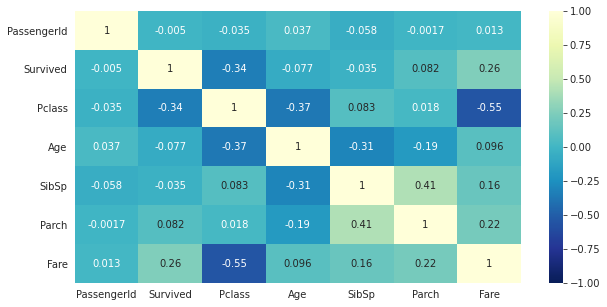

In [12]:
# Correlation betwenn columns
plt.figure(figsize=[10,5])
sns.heatmap(Train_df.corr(), vmax= 1, vmin= -1, annot= True, cmap= "YlGnBu_r")

 ` * From Above Correlation, Fare is one of the importent feature for Survival `

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

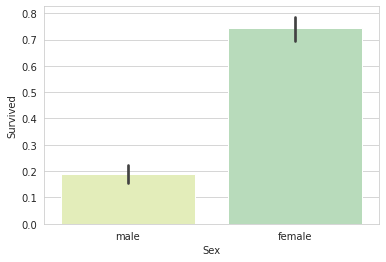

In [13]:
# Checking Sex wise Survival
sns.barplot(Train_df["Sex"],Train_df["Survived"])

`* Female Passgers are survived more than male, M first priority ` 

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

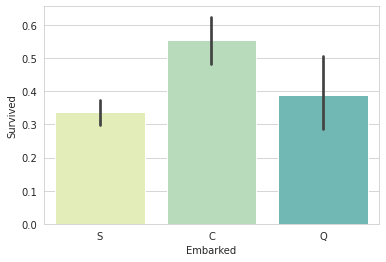

In [14]:
# Checking Embarked wise Survival
sns.barplot(Train_df["Embarked"],Train_df["Survived"])

 `* C - Embarked Passngers are most survived than S and Q `

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

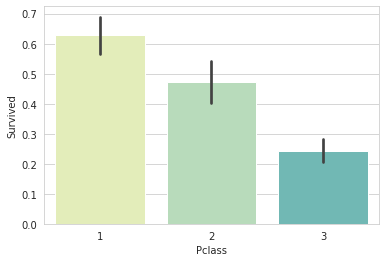

In [15]:
# Checking Sex wise Survival
sns.barplot(Train_df["Pclass"],Train_df["Survived"])

` * Pclass - 3 has lesser chance to survival 

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

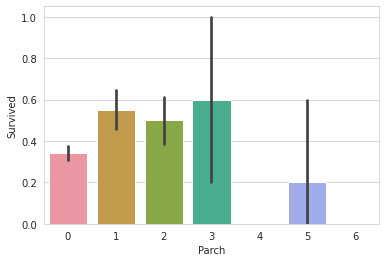

In [16]:
# Checking Parch wise Survival
sns.barplot(Train_df["Parch"],Train_df["Survived"])

 `* More than 3 Children's having family survival is very less`

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

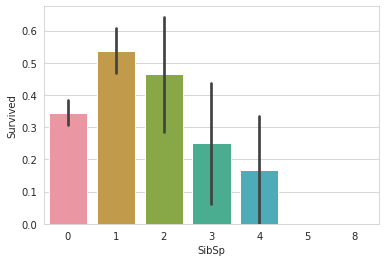

In [17]:
# Checking SibSP wise Survival
sns.barplot(Train_df["SibSp"],Train_df["Survived"])

` * Higer Siblings has lesser survival count`

<AxesSubplot:xlabel='Fare'>

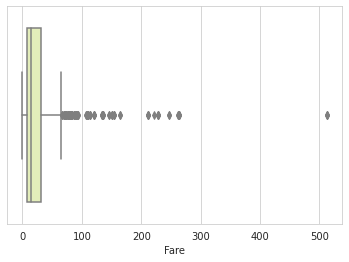

In [18]:
# Fare Box Plot 

sns.boxplot(Train_df["Fare"])

`* Fare has outliers which needs to be taken care in the same time fare also correlated with Survaival so, we cant throw away those outliers blindly` 

In [19]:
# Replacing Ticket fare more than 60 to 60
Train_df['Fare'] = Train_df['Fare'].replace([Train_df['Fare'].iloc[Train_df['Fare'].values >= 60]], 60)
Test_df['Fare'] = Test_df['Fare'].replace([Test_df['Fare'].iloc[Test_df['Fare'].values >= 60]], 60)

<AxesSubplot:xlabel='Fare'>

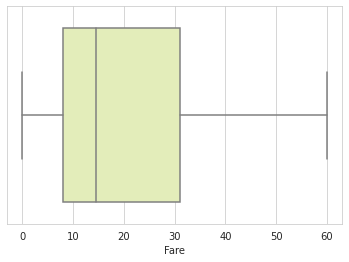

In [20]:
sns.boxplot(Train_df["Fare"])

<AxesSubplot:xlabel='Age', ylabel='Count'>

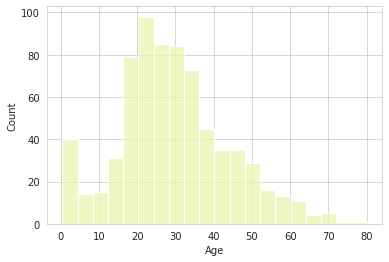

In [21]:
# Age Plot

sns.histplot(Train_df["Age"])

`* Note : we need to take care of the Missing Values `

## `Feature Engineering`

In [22]:
Train_df.Ticket.head(30)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
20              239865
21              248698
22              330923
23              113788
24              349909
25              347077
26                2631
27               19950
28              330959
29              349216
Name: Ticket, dtype: object

In [23]:
# We need to remove the String Values in the ticket
Values = Train_df['Ticket']
Ticket =[]
for x in Values:
    if not x.isdigit():
        if x =="LINE":
            Ticket.append(0)
        else:  
            Ticket.append(x.split(" ")[-1])
    else:
        Ticket.append(x)
Train_df['Ticket'] = Ticket

In [24]:
Values = Test_df['Ticket']
Ticket =[]
for x in Values:
    if not x.isdigit():
        if x =="LINE":
            Ticket.append(0)
        else:  
            Ticket.append(x.split(" ")[-1])
    else:
        Ticket.append(x)
Test_df['Ticket'] = Ticket

In [25]:

Train_df['Ticket'] = Train_df['Ticket'].astype(int)
Test_df['Ticket'] = Test_df['Ticket'].astype(int)

In [26]:
# Working on Name
Train_Name = Train_df['Name']
Test_name = Test_df['Name']
Train_df['Name'] = [x.split(" ")[1] for x in Train_Name]
Test_df['Name'] =  [x.split(" ")[1] for x in Test_name]

In [27]:
len(Train_df['Name'].value_counts()),len(Test_df['Name'].value_counts())

(31, 16)

In [28]:
Train_df['Name'].unique(), Test_df['Name'].unique()

(array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Planke,', 'Don.', 'Rev.',
        'Billiard,', 'der', 'Walle,', 'Dr.', 'Pelsmaeker,', 'Mulder,', 'y',
        'Steen,', 'Carlo,', 'Mme.', 'Impe,', 'Ms.', 'Major.', 'Gordon,',
        'Messemaeker,', 'Mlle.', 'Col.', 'Capt.', 'Velde,', 'the',
        'Shawah,', 'Jonkheer.', 'Melkebeke,', 'Cruyssen,'], dtype=object),
 array(['Mr.', 'Mrs.', 'Miss.', 'Carlo,', 'Khalil,', 'Master.', 'y', 'Ms.',
        'Palmquist,', 'Col.', 'Planke,', 'Rev.', 'Billiard,',
        'Messemaeker,', 'Dr.', 'Brito,'], dtype=object))

`* From Above title we cant add much value to the analysis as test and train title are diffrent 
also we alreday found that Feamle passengers has high survival ratio`

In [29]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    int64  
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(4)
memory usage: 83.7+ KB


In [30]:
# Dropping Cabin and Name Columns

X = Train_df.drop(['Name','Cabin'], axis=1)
Sub_test = Test_df.drop(['Name','Cabin'], axis=1)

In [31]:
X.shape,Sub_test.shape

((891, 10), (418, 9))

In [32]:
# Encoding Lables
Cat_columns = list(X.dtypes[X.dtypes == "object"].index)
Cat_columns


['Sex', 'Embarked']

In [33]:
LC = LabelEncoder()
for x in Cat_columns:
    X[x] = LC.fit_transform(X[x])
    Sub_test[x] = LC.fit_transform(Sub_test[x])


In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 69.7 KB


In [35]:
# Imputing Age 

data = [X, Sub_test]
for dataset in data:
    mean = X["Age"].mean()
    std = Sub_test["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # Random No generator
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # Imputing missing Values
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = X["Age"].astype(int)

In [36]:
X.isnull().sum()/len(X)*100

PassengerId    0.0
Survived       0.0
Pclass         0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Embarked       0.0
dtype: float64

## `Modeling`

In [37]:
# Taking out the Y from X
y = X.pop('Survived')

In [38]:
X.shape, y.shape

((891, 9), (891,))

In [39]:
# Trying out Naive Bayes
nb = GaussianNB()
nb.fit(X,y)
cross_val_score(nb, X,y, cv=10).mean()

0.6757677902621723

In [40]:
# Trying out Decision Tree
dt = DecisionTreeClassifier(random_state=seed)
dt.fit(X,y)
cross_val_score(dt, X,y,cv = 10 ).mean()

0.7452184769038702

In [41]:
# Trying out RandomForest
rf = RandomForestClassifier(random_state=seed)
rf.fit(X,y)
cross_val_score(rf, X,y, cv=15).mean()

0.8329378531073446

` * I am choosing Randomforest for teh final Model`

In [42]:
# Using Stratified Kfold With RF modle and finding the ROC
cv = StratifiedKFold(n_splits=5,shuffle=False)

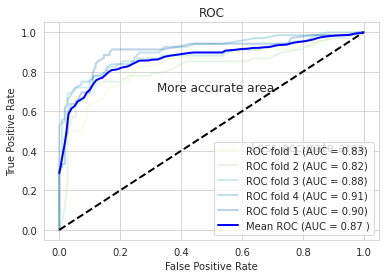

In [43]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i =1
for train,test in cv.split(X,y):
    prob = rf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])[:,1]
    fpr, tpr, t = roc_curve(y[test], prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()